In [18]:
import emcee
import matplotlib.pyplot as plt
import pyccl as ccl
import numpy as np
import corner

print(emcee.__version__)

3.1.6


In [51]:

# Read the HDF5 file (note: no need to reset the backend here)
filename = "/home/c2042999/PCA_project/Likelihood_estimation_3x2pt_fsigma8/mcmc/mcmc_fR_gamma_progress.h5"
filename = "/home/c2042999/PCA_project/mcmc_fR_gamma_progress_old.h5"

while True:
    try:
        reader = emcee.backends.HDFBackend(filename, read_only=True)
        break  # Exit the loop once file is read successfully
    except BlockingIOError:
        # Wait for some time before retrying
        print("File is locked, retrying...")
        time.sleep(0.1)  # Sleep for 1 second before trying again

# Check how many steps have been completed so far
n_steps_completed = reader.iteration
print(f"Number of steps completed: {n_steps_completed}")

# You can also manually access the raw chain and other properties
raw_chain = reader.get_chain()
print(f"Current raw chain shape: {raw_chain.shape}")



tau = reader.get_autocorr_time(tol=0)
max_tau_ratio = np.max(tau * 100 / reader.iteration)
converged = max_tau_ratio < 1
print("Current iteration: {}".format(reader.iteration))
print("Max 100 x Tau/N: {}".format(max_tau_ratio))


Number of steps completed: 270
Current raw chain shape: (270, 56, 12)
Current iteration: 270
Max 100 x Tau/N: 14.451443939129785


In [52]:
# Define cosmology


cosmo_universe = ccl.Cosmology(Omega_c = 0.26962, 
                          Omega_b = 0.049453, 
                          h = 0.6688, 
                          n_s = 0.9626,
                          A_s = 2.092e-9)

cosmo_universe = ccl.Cosmology(Omega_c = 0.27, 
                        Omega_b = 0.046, 
                        h = 0.7, 
                        n_s = 0.974,
                        A_s = 2.01e-9)

Bias_distribution_fiducial = np.array([1.229,
                             1.362,
                             1.502,
                             1.648,
                             1.799])

In [53]:
labels = [r"$\Omega_c$", r"$\mu_0$",r"$\Sigma_0$", r"$10^{9}A_s$", r"$h$", r"$n_s$", r"$\omega_b$",\
         r'$b_1$', r'$b_2$', r'$b_3$', r'$b_4$', r'$b_5$']

value1 = [cosmo_universe["Omega_c"], 0.0, 0.0, cosmo_universe["A_s"]*1e9, cosmo_universe["h"],\
          cosmo_universe["n_s"],cosmo_universe["Omega_b"]*cosmo_universe["h"]**2,\
         Bias_distribution_fiducial[0], Bias_distribution_fiducial[1],\
         Bias_distribution_fiducial[2],Bias_distribution_fiducial[3],\
         Bias_distribution_fiducial[4]]

sampler_PCA_arr_musig = np.load("/home/c2042999/PCA_project/chains/3x2pt_DEparam_bias/fR_DEParam_PCAcut.npy")

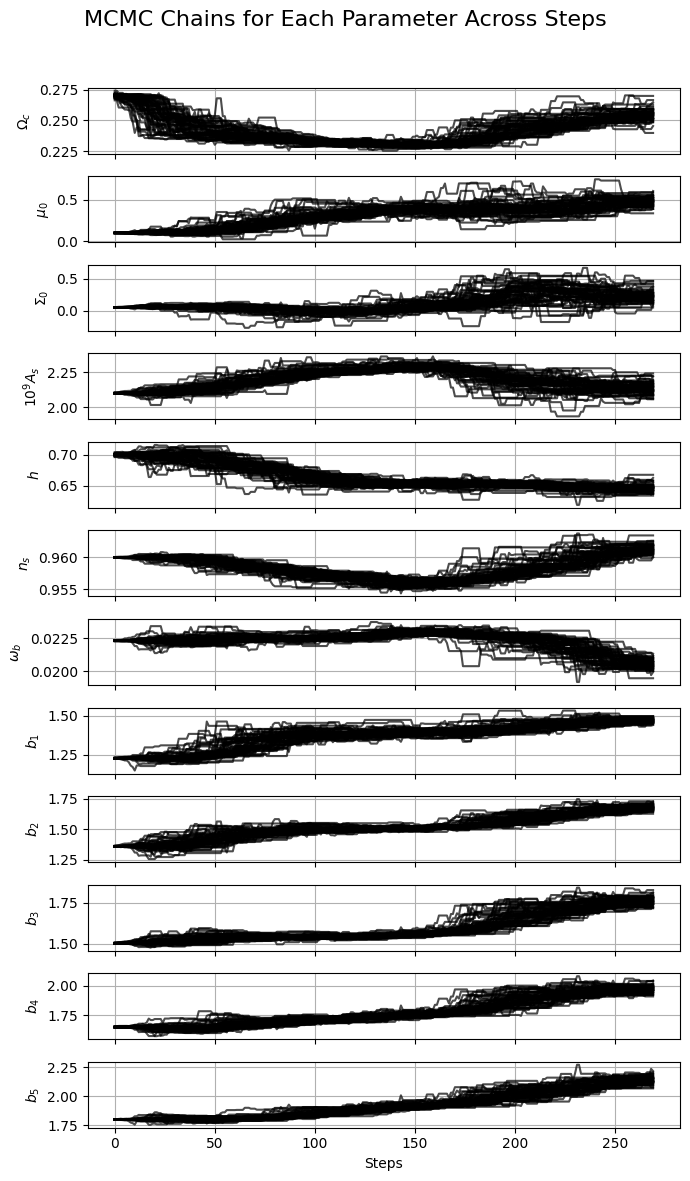

In [54]:
# Assuming `raw_chain` is the MCMC chain you have loaded from the file.
n_steps, n_walkers, n_params = raw_chain.shape

# Create a figure with subplots, one for each parameter
fig, axes = plt.subplots(n_params, figsize=(7, n_params), sharex=True)

# Iterate over each parameter and plot its evolution
for i in range(n_params):
    ax = axes[i]
    for j in range(n_walkers):
        ax.plot(raw_chain[:, j, i], alpha=0.7, color="k")  # Plot for each walker
    ax.set_ylabel(labels[i])
    ax.grid()

# Add a label for the shared x-axis (steps/iterations)
axes[-1].set_xlabel("Steps")

# Set the overall title and adjust layout
plt.suptitle("MCMC Chains for Each Parameter Across Steps", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()

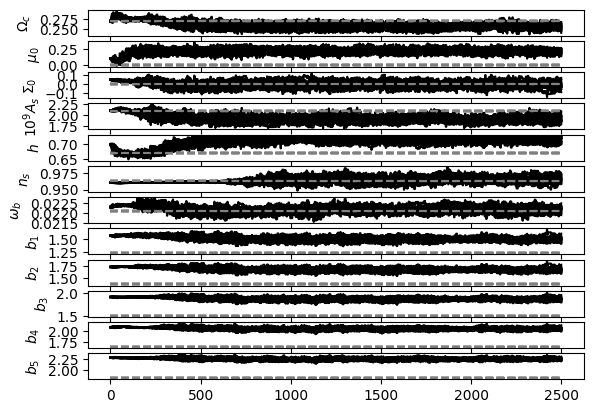

In [22]:
fig, ax = plt.subplots(len(sampler_PCA_arr_musig[0, 0, :]), sharex=True)

for i in range(len(sampler_PCA_arr_musig)):
    for j in range(len(sampler_PCA_arr_musig[0, 0, :])):
        ax[j].plot(sampler_PCA_arr_musig[i, :, j], color = "black")
        ax[j].plot([0,len(sampler_PCA_arr_musig[0, :, 0])],[value1[j],value1[j]], color="gray", linestyle="--")
        ax[j].set_ylabel(labels[j])
        

(37500, 7)
(20680, 7)


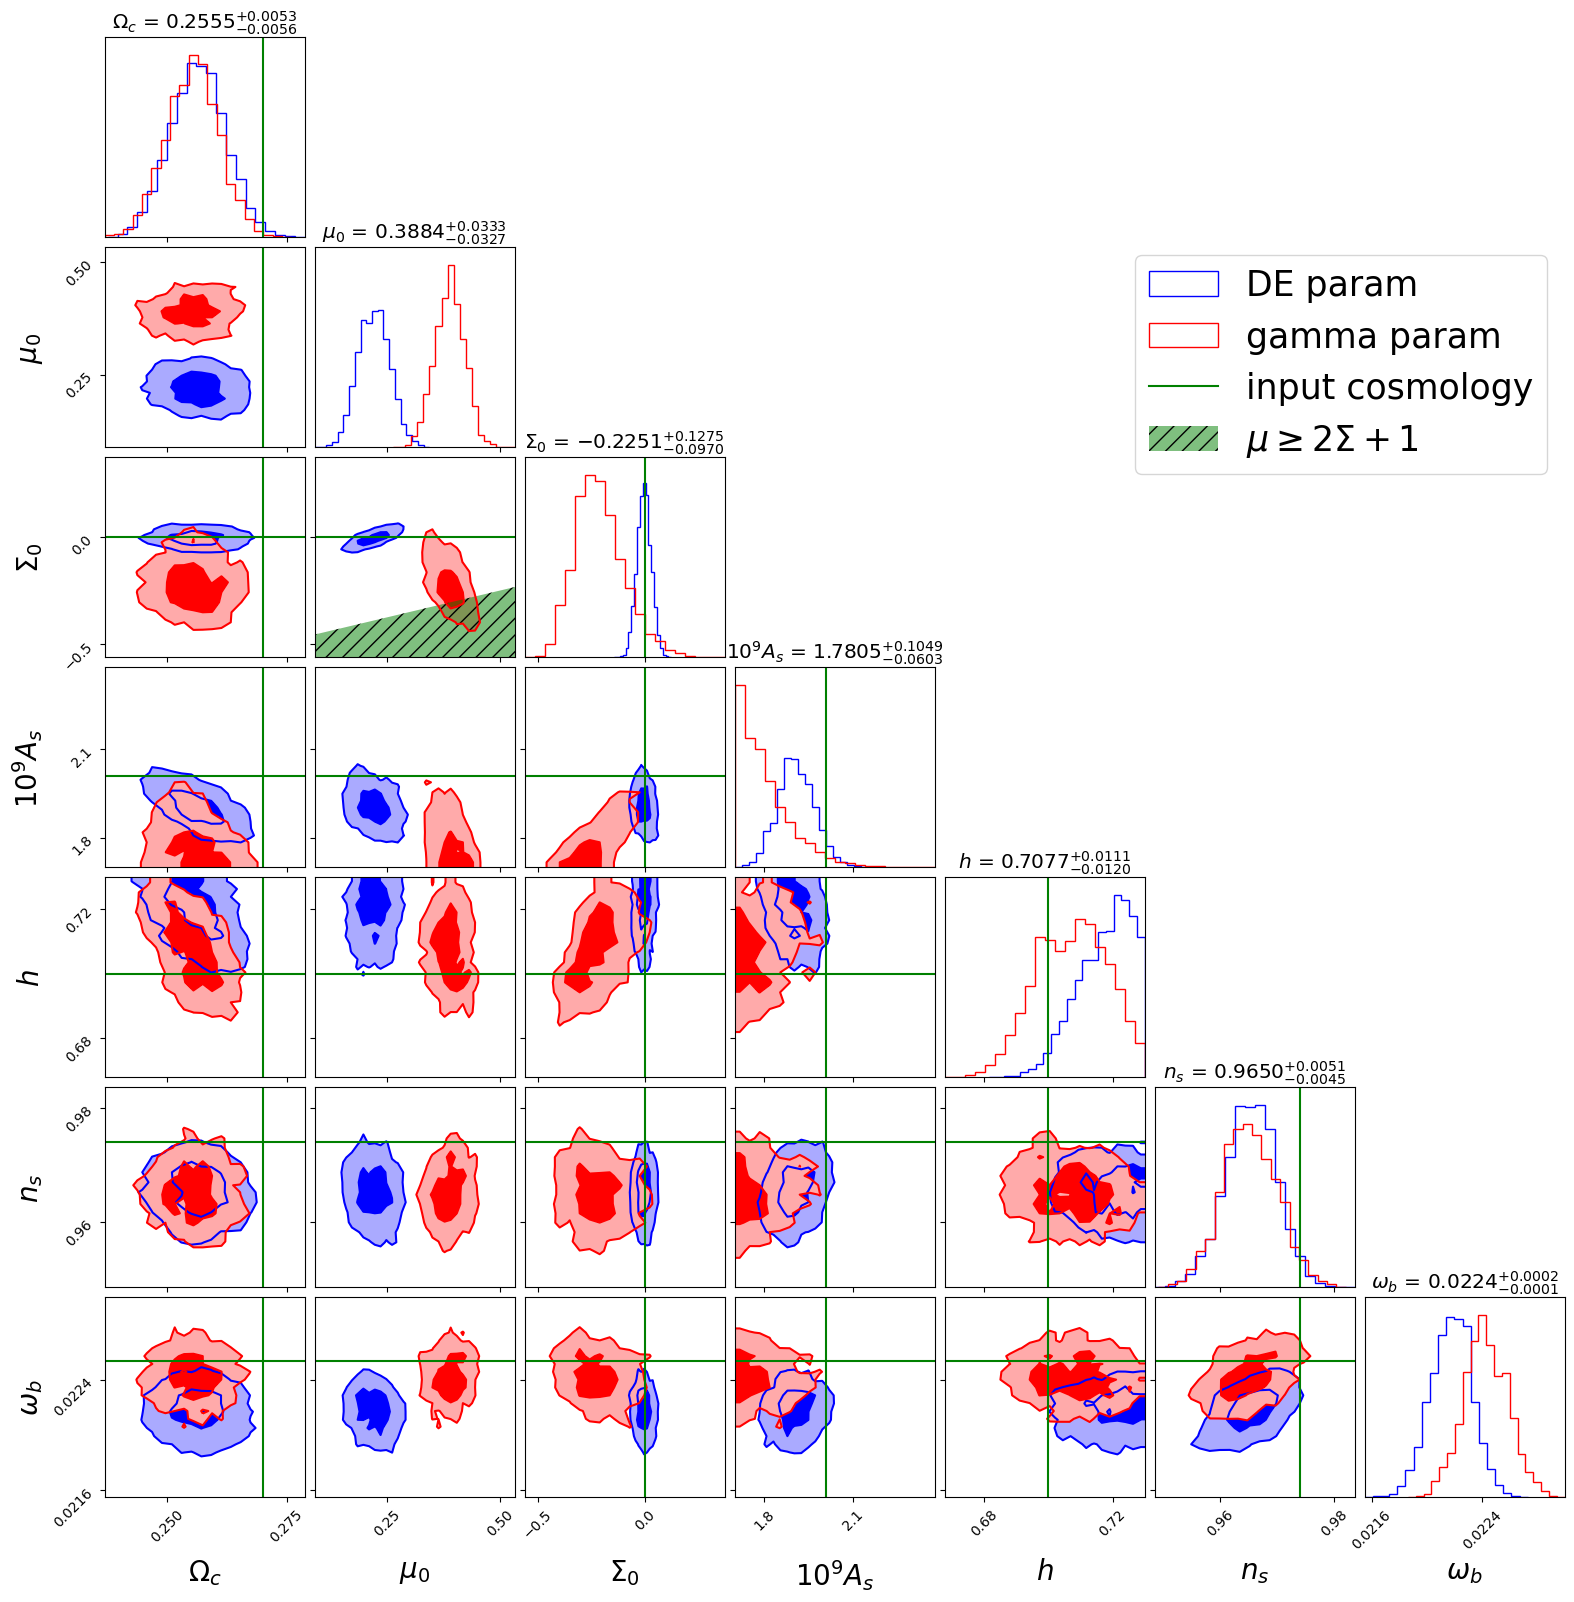

In [42]:
### PCA CUTS - mu/Sigma ####
burnin = 1000
ndim = 7#len(labels)
final_length_musig = len(sampler_PCA_arr_musig)*(len(sampler_PCA_arr_musig[0])-burnin)

CORNER_KWARGS_musig = dict(
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_density=False,
    plot_datapoints=False,
    plot_contours=True,
    fill_contours=True)


flat_samples = sampler_PCA_arr_musig[:,burnin:].reshape(final_length_musig,len(labels))[:,:ndim]

figure = corner.corner(
    flat_samples, **CORNER_KWARGS_musig, labels=labels, color="b"
);
print(flat_samples.shape)

### PCA CUTS - gamma ####

burnin = 600
burned_chain = raw_chain[burnin:, :, :]

final_length = len(sampler_PCA_arr)*(len(sampler_PCA_arr[0])-burnin)
CORNER_KWARGS = dict(
    label_kwargs=dict(fontsize=20),
    title_kwargs=dict(fontsize=14.5),
    show_titles=True,
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=True,
    max_n_ticks=2,
    title_fmt=".4f",
    weights = np.ones(final_length) * (final_length_musig / final_length)

)

flat_samples =  burned_chain.reshape(-1, n_params)[:,:ndim]

print(flat_samples.shape)

corner.corner(
    flat_samples, **CORNER_KWARGS, labels=labels, fig=figure, color = "r"
);

######################

# Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))

# Loop over the diagonal
for i in range(ndim):
    ax = axes[i, i]
    ax.axvline(value1[i], color="g")

# Loop over histograms
for yi in range(ndim):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(value1[xi], color="g")
        ax.axhline(value1[yi], color="g")

# Plot prior on mu/Sigma for numerical instability
mu_0_array_plot = np.linspace(-1,4,10)
axes[2, 1].fill_between(mu_0_array_plot,(mu_0_array_plot - 1)/2,   min((mu_0_array_plot - 1)/2), hatch="//", facecolor="g", alpha=.5)
#mu0 <= 2*Sigma0 + 1.0 

axes[-1, -1].fill_between(mu_0_array_plot,(mu_0_array_plot - 1)/2,   min((mu_0_array_plot - 1)/2), hatch="//", facecolor="g", alpha=.5)
plt.legend(["DE param","gamma param","input cosmology",r"$\mu \geq 2 \Sigma + 1$"], bbox_to_anchor=(1.0, 6.3), fontsize=25)
axes[-1, -1].lines[-1].remove()  # remove the first line in ax1

#plt.savefig("/home/c2042999/PCA_project/Figures/3x2pt_fsigma8_Planckpriors_fR_cutcompare_marg.pdf", bbox_inches='tight')